In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#def load_and_preprocess_data(file_path):
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].fillna('NA')
        elif np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].fillna(0)
    return df

In [3]:
data = load_and_preprocess_data(r"C:\Users\Abdullahi Mujaheed\Desktop\mlzoom\course_lead_scoring.csv")
data

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [4]:
train, val = train_test_split(data, test_size= .4, random_state=1)

In [5]:
val, test = train_test_split(val, test_size= .5, random_state=1)

In [6]:
y_train = train['converted'].values
y_val = val['converted'].values
y_test = test['converted'].values

x_train = train.drop(columns=['converted'])
x_val = val.drop(columns=['converted'])
x_test = test.drop(columns=['converted'])

In [7]:
from sklearn.metrics import roc_auc_score

In [ ]:
'''def num_col(df, y):
    scores = {}
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            x = np.unique(df[col].values)
            if x.size <= 1:
                continue
            try:
                roc = roc_auc_score(y.values, x)
            except Exception:
                continue
            if roc < .5:
                try:
                    roc = roc_auc_score(y.values, -x)
                except Exception:
                    pass
            scores[col] = roc
    df_scores = pd.DataFrame.from_dict(scores, orient= 'index', columns=['auc_score'])
    return df_scores'''

In [9]:
def num_col(df, y):
    # initialize empty dict
    scores = {}

    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.number):
            x = df[col].values
                # skip constant feature
            if np.unique(x).size <= 1:
                continue
            try:
                roc = roc_auc_score(y, x)
            except Exception:
                    continue
                # flip sign if AUC < 0.5
            if roc < 0.5:
                try:
                    roc = roc_auc_score(y, -x)
                except Exception:
                    pass
                # append to dict
            scores[col] = roc

        # convert dict to DataFrame
    df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['auc']).sort_values('auc', ascending=False)
    return df_scores
    # ...existing code...
# ...existing code...

In [11]:
new = num_col(x_train, y_train)
new

,auc
number_of_courses_viewed,0.765244
interaction_count,0.727191
lead_score,0.611117
annual_income,0.544635


In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
vect = DictVectorizer()

In [44]:
def cat_extract(df):
    return df[['lead_source', 'industry', 'employment_status', 'location']].to_dict(orient='records')

In [41]:
train_dict = vect.fit_transform(dict).toarray()

In [43]:
log_reg.fit(train_dict, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
val_dict = cat_extract(x_val)

In [47]:
val_dict

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]], shape=(292, 27))

In [46]:
val_dict = vect.transform(val_dict).toarray()

In [52]:
val_pred = log_reg.predict(val_dict)

In [54]:
val_auc = roc_auc_score(y_val, val_pred)
val_auc

0.6136458333333332

In [55]:
from sklearn.metrics import precision_score, recall_score

In [57]:
val_prob = log_reg.predict_proba(val_dict)[:, 1]

In [68]:
prec_val = []
rec_val = []
thresholds = np.arange(0.0, 1.01, 0.01)

In [69]:
for t in thresholds:
    t_val = (val_prob >= t).astype(int)
    precisions = precision_score(y_val, t_val)
    recalls = recall_score(y_val, t_val)
    prec_val.append(precisions)
    rec_val.append(recalls)
    #f_score = (2*precisions*recalls)/(precisions + recalls)
    #f_scores.append(f_score)

c:\Users\Abdullahi Mujaheed\Desktop\elevvo\elevvo-bootcamp\elevvo-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Abdullahi Mujaheed\Desktop\elevvo\elevvo-bootcamp\elevvo-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Abdullahi Mujaheed\Desktop\elevvo\elevvo-bootcamp\elevvo-venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this b

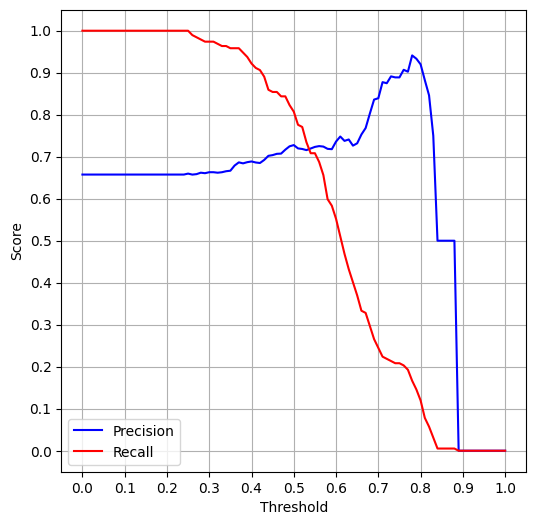

In [65]:
plt.figure(figsize=(6,6))
plt.plot(thresholds, prec_val, label='Precision', color='blue')
plt.plot(thresholds, rec_val, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.legend()
plt.grid()
plt.show()

In [89]:
f1_score = []
for t, p, r in zip(thresholds, prec_val, rec_val):
    if p + r > 0:
        try :
            f1 = round((2*p*r)/(p + r), 2)
        except ZeroDivisionError:
            f1 = 0
    f1_score.append((t, f1))


In [92]:
np.max(f1_score)

np.float64(1.0)